# Machine Learning models on Mismatch Response data

In this notebook: 
- Necessary imports
- SVM model 
- Logistic Regression model
- Decision Tree model

## Imports

In [3]:
import os       # using operating system dependent functionality (folders)
import pandas as pd # data analysis and manipulation
import numpy as np    # numerical computing (manipulating and performing operations on arrays of data)
import copy     # Can Copy and Deepcopy files so original file is untouched.
import seaborn as sn
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../eegyolk') # path to helper functions
import helper_functions as hf # library useful for eeg and erp data cleaning
import epod_helper

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold 

In [4]:
df = pd.read_csv('df_avg_mmr.csv', sep = ',')
df.head()

,Group_AccToParents,mean_AF3,mean_AF4,mean_C3,mean_C4,mean_CP1,mean_CP2,mean_CP5,mean_CP6,mean_Cz,...,var_P8,var_PO3,var_PO4,var_Pz,var_T7,var_T8,ParticipantID,test,sex,age_months
0,1,-0.307508,-1.117406,-0.265137,-2.490048,-0.344755,-1.952034,0.244291,-2.060369,-0.430365,...,4.081511,2.823812,3.707833,1.865558,1.246092,4.157734,101,a,1,20
1,1,-1.565712,-0.481950,0.163128,2.782407,2.052576,3.038309,-2.244892,4.449279,1.505256,...,18.145947,5.509024,10.550081,10.769883,4.609330,10.190182,103,a,0,20
2,1,-0.059614,-0.635098,0.239789,0.663436,0.053435,-0.615029,0.613740,1.628879,-0.009549,...,3.938772,1.845088,2.675353,1.101257,1.635812,6.517099,104,a,1,18
3,1,1.518115,3.254148,0.475445,0.239900,0.444679,-0.945208,1.471047,0.360562,0.115756,...,5.143383,0.971683,1.688680,1.125295,11.474910,6.965740,105,a,0,17
4,1,1.222853,-0.210978,0.100778,2.893458,-0.791865,1.849126,2.886796,2.436897,0.329421,...,4.983561,2.879790,4.470761,1.911889,2.732053,2.822238,106,a,1,19


In [5]:
features_of_interest = df[['mean_AF3',
 'mean_F3',
 'mean_F7',
 'mean_FC1',
 'mean_FC5',
 'mean_Fp1',
 'mean_Fz',
 'kurt_AF3',
 'kurt_F3',
 'kurt_F7',
 'kurt_FC1',
 'kurt_FC5',
 'kurt_Fp1',
 'kurt_Fz',
 'skew_AF3',
 'skew_F3',
 'skew_F7',
 'skew_FC1',
 'skew_FC5',
 'skew_Fp1',
 'skew_Fz',
 'std_AF3',
 'std_F3',
 'std_F7',
 'std_FC1',
 'std_FC5',
 'std_Fp1',
 'std_Fz',
 'var_AF3',
 'var_F3',
 'var_F7',
 'var_FC1',
 'var_FC5',
 'var_Fp1',
 'var_Fz',
 'sex',
 'age_months']]

In [6]:
dfcor = features_of_interest.corr()

In [7]:
dfcor

,mean_AF3,mean_F3,mean_F7,mean_FC1,mean_FC5,mean_Fp1,mean_Fz,kurt_AF3,kurt_F3,kurt_F7,...,std_Fz,var_AF3,var_F3,var_F7,var_FC1,var_FC5,var_Fp1,var_Fz,sex,age_months
mean_AF3,1.000000,0.760252,0.612593,0.371649,0.538782,0.757020,0.634685,0.184305,0.011962,0.102379,...,-0.233714,-0.039452,0.047652,-0.115772,-0.282776,-0.212739,-0.111935,-0.238238,0.167581,-0.052079
mean_F3,0.760252,1.000000,0.554842,0.381629,0.648737,0.570191,0.535846,0.154770,0.176982,0.054953,...,-0.210012,0.053119,0.226073,-0.012189,-0.230439,-0.273496,-0.054699,-0.201018,-0.001419,-0.193227
mean_F7,0.612593,0.554842,1.000000,0.158475,0.582412,0.602392,0.367365,0.159851,0.076886,0.269169,...,-0.239597,-0.068077,0.082373,0.010780,-0.232877,-0.178415,-0.053001,-0.259696,0.030904,-0.073495
mean_FC1,0.371649,0.381629,0.158475,1.000000,0.236148,0.345738,0.572561,0.077348,0.103155,-0.022802,...,-0.229493,-0.271091,-0.037613,-0.279028,-0.365870,-0.308249,-0.116493,-0.200273,0.020988,0.001343
mean_FC5,0.538782,0.648737,0.582412,0.236148,1.000000,0.513245,0.330963,0.078577,0.105242,0.084589,...,-0.168347,0.032812,-0.066616,0.045581,-0.172261,-0.428837,0.008976,-0.180397,-0.010318,-0.182217
mean_Fp1,0.757020,0.570191,0.602392,0.345738,0.513245,1.000000,0.503007,0.067061,-0.032292,0.095215,...,-0.204565,-0.012056,-0.000874,-0.099912,-0.242820,-0.180095,0.244253,-0.202355,0.148732,-0.138189
mean_Fz,0.634685,0.535846,0.367365,0.572561,0.330963,0.503007,1.000000,0.204027,0.176656,0.076905,...,-0.106180,-0.120781,-0.003522,-0.042638,-0.183653,-0.150511,-0.062217,-0.077337,0.123209,-0.010200
kurt_AF3,0.184305,0.154770,0.159851,0.077348,0.078577,0.067061,0.204027,1.000000,0.664190,0.357424,...,-0.115982,-0.304051,-0.077969,-0.048431,-0.106701,0.012445,-0.152006,-0.094509,0.027693,0.093458
kurt_F3,0.011962,0.176982,0.076886,0.103155,0.105242,-0.032292,0.176656,0.664190,1.000000,0.465030,...,-0.017909,-0.127791,-0.105129,-0.002361,-0.082874,-0.027382,-0.079924,0.000652,0.079604,0.112696
kurt_F7,0.102379,0.054953,0.269169,-0.022802,0.084589,0.095215,0.076905,0.357424,0.465030,1.000000,...,-0.168483,-0.169776,-0.102487,-0.132724,-0.049153,-0.085015,-0.156343,-0.167616,0.060608,0.252721


In [8]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(dfcor, 50))

Top Absolute Correlations
std_FC5   var_FC5     0.998514
std_AF3   var_AF3     0.996387
std_F7    var_F7      0.995526
std_Fz    var_Fz      0.995343
std_FC1   var_FC1     0.994038
std_Fp1   var_Fp1     0.988271
kurt_FC1  kurt_Fz     0.969674
mean_AF3  mean_F3     0.943473
          mean_Fp1    0.938643
std_FC1   var_Fz      0.922767
          std_Fz      0.915511
std_AF3   std_Fp1     0.912788
var_FC1   var_Fz      0.911301
mean_F3   mean_FC5    0.910391
std_F3    var_F3      0.907657
mean_AF3  mean_Fz     0.903723
std_Fp1   var_AF3     0.903146
mean_AF3  mean_F7     0.901083
mean_FC1  mean_Fz     0.897071
std_AF3   std_F7      0.896904
std_Fz    var_FC1     0.896805
std_F7    std_FC5     0.888046
kurt_AF3  kurt_F3     0.886946
std_F7    std_Fp1     0.886540
skew_AF3  skew_Fp1    0.884566
mean_F3   mean_F7     0.880210
std_F7    var_FC5     0.877309
          var_AF3     0.876377
skew_AF3  skew_F3     0.876183
mean_F3   mean_Fp1    0.875113
std_AF3   var_F7      0.874937
std_Fp1   var

## Split data

In [35]:
y = df['Group_AccToParents'].values # dependant variable
X = df[['mean_AF3',
 'mean_F3',
 'mean_F7',
 'mean_FC1',
 'mean_FC5',
 'mean_Fp1',
 'mean_Fz',
 'kurt_AF3',
 'kurt_F3',
 'kurt_F7',
 'kurt_FC1',
 'kurt_FC5',
 'kurt_Fp1',
 'kurt_Fz',
 'skew_AF3',
 'skew_F3',
 'skew_F7',
 'skew_FC1',
 'skew_FC5',
 'skew_Fp1',
 'skew_Fz',
 'std_AF3',
 'std_F3',
 'std_F7',
 'std_FC1',
 'std_FC5',
 'std_Fp1',
 'std_Fz'
    ]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

## Scale data

In [36]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

In [37]:
pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

## SVM model

In [38]:
svm = SVC()
parameters = {'kernel':('linear', 'rbf'), 'C':[0.001, 1]}
clf = GridSearchCV(svm, parameters)
clf.fit(X_train, y_train)

sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_C',
 'param_kernel',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [39]:
clf.best_params_

{'C': 0.001, 'kernel': 'linear'}

In [40]:
clf.score(X_train, y_train)

0.5333333333333333

In [41]:
svm = SVC(C=1, kernel='linear', random_state=False)
svm.fit(X_train, y_train)

SVC(C=1, kernel='linear', random_state=False)

In [42]:
y_pred = svm.predict(X_test)
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.561


In [43]:
y_pred

array([0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1])

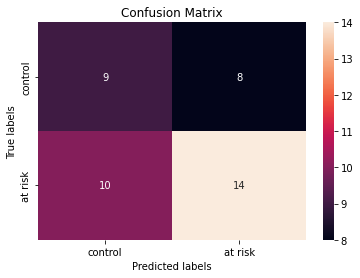

In [44]:
cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['control', 'at risk']); ax.yaxis.set_ticklabels(['control', 'at risk']);

In [45]:
# with kfold cross validation
k = 3
kf = KFold(n_splits=k, random_state=None)
model = svm
 
acc_score = []
 
for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
     
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)
     
    acc = accuracy_score(pred_values , y_test)
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k
 
print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))

accuracy of each fold - [0.3235294117647059, 0.4411764705882353, 0.5151515151515151]
Avg accuracy : 0.4266191325014854


## Logistic Regression model

In [46]:
lr = LogisticRegression(solver='liblinear', random_state=0)
lr.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [47]:
y_pred = lr.predict(X_test)

In [48]:
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.636


In [49]:
y_pred

array([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0])

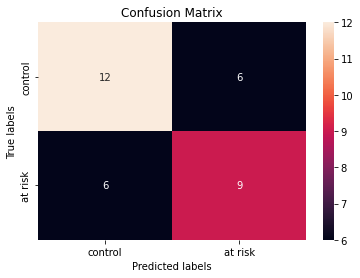

In [50]:
cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['control', 'at risk']); ax.yaxis.set_ticklabels(['control', 'at risk']);

In [26]:
# with kfold cross validation
k = 3
kf = KFold(n_splits=k, random_state=None)
model = lr
 
acc_score = []
 
for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
     
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)
     
    acc = accuracy_score(pred_values , y_test)
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k
 
print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))

accuracy of each fold - [0.35294117647058826, 0.4117647058823529, 0.6363636363636364]
Avg accuracy : 0.4670231729055258


## Decision Tree model

In [27]:
dt = tree.DecisionTreeClassifier(max_depth=5)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [28]:
y_pred = dt.predict(X_test)

In [29]:
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.485


In [30]:
y_pred

array([1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1])

[Text(0.375, 0.9166666666666666, 'X[25] <= 0.969\ngini = 0.496\nsamples = 68\nvalue = [31, 37]'),
 Text(0.14285714285714285, 0.75, 'X[9] <= -1.179\ngini = 0.111\nsamples = 17\nvalue = [1, 16]'),
 Text(0.07142857142857142, 0.5833333333333334, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.21428571428571427, 0.5833333333333334, 'gini = 0.0\nsamples = 16\nvalue = [0, 16]'),
 Text(0.6071428571428571, 0.75, 'X[10] <= -0.787\ngini = 0.484\nsamples = 51\nvalue = [30, 21]'),
 Text(0.35714285714285715, 0.5833333333333334, 'X[10] <= -1.177\ngini = 0.483\nsamples = 22\nvalue = [9, 13]'),
 Text(0.21428571428571427, 0.4166666666666667, 'X[27] <= 2.886\ngini = 0.245\nsamples = 7\nvalue = [6, 1]'),
 Text(0.14285714285714285, 0.25, 'gini = 0.0\nsamples = 6\nvalue = [6, 0]'),
 Text(0.2857142857142857, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.5, 0.4166666666666667, 'X[9] <= -0.855\ngini = 0.32\nsamples = 15\nvalue = [3, 12]'),
 Text(0.42857142857142855, 0.25, 'X[20] <= 0.131\ngini 

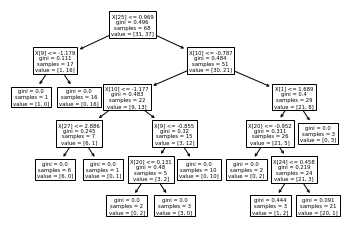

In [31]:
tree.plot_tree(dt)

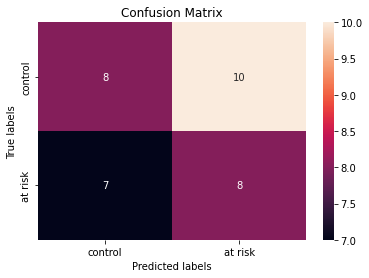

In [32]:
cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['control', 'at risk']); ax.yaxis.set_ticklabels(['control', 'at risk']);

In [33]:
# with kfold cross validation
k = 3
kf = KFold(n_splits=k, random_state=None)
model = tree.DecisionTreeClassifier(max_depth=5)
 
acc_score = []
 
for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
     
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)
     
    acc = accuracy_score(pred_values , y_test)
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k
 
print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))

accuracy of each fold - [0.4411764705882353, 0.4117647058823529, 0.45454545454545453]
Avg accuracy : 0.43582887700534756
